In [1]:
import networkx as nx

from regraph import Rule, plot_rule
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

In [2]:
g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [3]:
res = g.clear()

In [4]:
nodes = ["a", "b", "c", "d", "e", "f"]
edges = [("a", "b"), ("d", "b"), ("a", "c"), ("e", "a"), ("f", "d")]
g.add_nodes_from(nodes)
g.add_edges_from(edges)

In [5]:
g.add_node("x")

In [6]:
g.add_edge("x", "c")

In [7]:
g.remove_edge("x", "c")

In [8]:
g.remove_node("x")

In [9]:
g.nodes()

['e', 'f', 'a', 'b', 'c', 'd']

In [10]:
g.edges()

[('e', 'a'), ('d', 'b'), ('a', 'b'), ('a', 'c'), ('f', 'd')]

In [11]:
res_clone_1 = g.clone_node('a')
print("Created clone by the name: ", res_clone_1)

MATCH (x:node { id : 'a' }) WITH [] as ignoredNodes, x OPTIONAL MATCH (x)-[:edge]->(succ) OPTIONAL MATCH (pred)-[:edge]->(x) WITH collect(succ) as listSucc, collect(pred) as listPred, ignoredNodes as ig, x OPTIONAL MATCH (same_id_node:node { id : 'a'}) WITH same_id_node, listSucc, listPred, ig,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, x WITH same_id_node, same_id_node_new_count, 'a' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as uid, filter(varNode in listSucc WHERE NOT (varNode.id in ig)) AS filtSucc, filter(varNode in listPred WHERE NOT (varNode.id in ig)) AS filtPred, x MERGE (new_node:node {id : uid }) SET same_id_node.count = same_id_node_new_count + 1 FOREACH (succ in filtSucc | MERGE (new_node)-[:edge]->(succ)) FOREACH (pred in filtPred | MERGE (pred)-[:edge]->(new_node)) RETURN uid 
Created clone by the name:  a1


In [12]:
res_clone_2 = g.clone_node('a', 'a_clone')
print("Created clone by the name: ", res_clone_2)

MATCH (x:node { id : 'a' }) WITH [] as ignoredNodes, x OPTIONAL MATCH (x)-[:edge]->(succ) OPTIONAL MATCH (pred)-[:edge]->(x) WITH collect(succ) as listSucc, collect(pred) as listPred, ignoredNodes as ig, x OPTIONAL MATCH (same_id_node:node { id : 'a_clone'}) WITH same_id_node, listSucc, listPred, ig,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, x WITH same_id_node, same_id_node_new_count, 'a_clone' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as uid, filter(varNode in listSucc WHERE NOT (varNode.id in ig)) AS filtSucc, filter(varNode in listPred WHERE NOT (varNode.id in ig)) AS filtPred, x MERGE (new_node:node {id : uid }) SET same_id_node.count = same_id_node_new_count + 1 FOREACH (succ in filtSucc | MERGE (new_node)-[:edge]->(succ)) FOREACH (pred in filtPred | MERGE (pred)-[:edge]->(new_node)) RETURN uid 
Created clone by the name:  a_clone


In [13]:
res_merge = g.merge_nodes(["a", "b"])

In [14]:
res_merge

'a_b'

In [15]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y", "z", "a"])
pattern.add_edges_from([("x", "y"), ("y", "z"), ("z", "z"), ("z", "a")])

In [25]:
instances = g.find_matching(pattern)
print("Instances: ", instances)

MATCH (x:node), (y:node), (z:node), (a:node), (x)-[:edge]->(y), (y)-[:edge]->(z), (z)-[:edge]->(z), (z)-[:edge]->(a) RETURN x, y, z, a
Instances:  [{'x': 'a1', 'y': 'd_c', 'z': 'a_b', 'a': 'd_c'}, {'x': 'a_clone', 'y': 'd_c', 'z': 'a_b', 'a': 'd_c'}, {'x': 'e', 'y': 'a1', 'z': 'a_b', 'a': 'd_c'}, {'x': 'e', 'y': 'a_clone', 'z': 'a_b', 'a': 'd_c'}]


In [26]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
clone_name2, _ = rule.inject_clone_node("y")
rule.inject_remove_edge(clone_name2, "z")
rule.inject_remove_node("x")
rule.inject_merge_nodes(["y", "a"])
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", "z")

/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/eugenia/anaconda3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


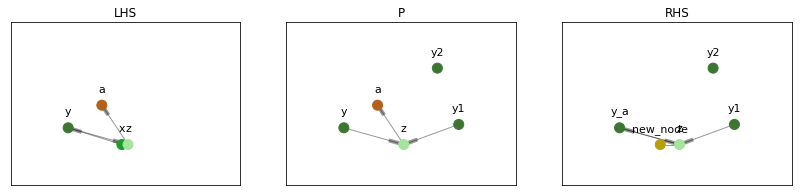

In [30]:
plot_rule(rule)

In [28]:
instances[0]

{'a': 'd_c', 'x': 'a1', 'y': 'd_c', 'z': 'a_b'}

In [20]:
rhs_g = g.rewrite(rule, instances[0])
print("\n\nRewriting rule to commands: \n")
print(rule.to_commands())

MATCH (x:node { id : 'f'}), (y:node { id : 'd'}), (z:node { id : 'a_b'}), (a:node { id : 'c'}) , (x)-[x_y:edge]->(y), (y)-[y_z:edge]->(z), (z)-[z_z:edge]->(z), (z)-[z_a:edge]->(a)WITH ['a_b'] as ignoredNodes, z, y, a, x OPTIONAL MATCH (y)-[:edge]->(succ) OPTIONAL MATCH (pred)-[:edge]->(y) WITH collect(succ) as listSucc, collect(pred) as listPred, ignoredNodes as ig, z, y, a, x OPTIONAL MATCH (same_id_node:node { id : 'y2'}) WITH same_id_node, listSucc, listPred, ig,  CASE WHEN same_id_node IS NOT NULL THEN (coalesce(same_id_node.count, 0) + 1) ELSE 0 END AS same_id_node_new_count, z, y, a, x WITH same_id_node, same_id_node_new_count, 'y2' + CASE WHEN same_id_node_new_count <> 0 THEN toString(same_id_node_new_count) ELSE '' END as y2_clone_id, filter(varNode in listSucc WHERE NOT (varNode.id in ig)) AS filtSucc, filter(varNode in listPred WHERE NOT (varNode.id in ig)) AS filtPred, z, y, a, x MERGE (y2:node {id : y2_clone_id }) SET same_id_node.count = same_id_node_new_count + 1 FOREACH 

In [21]:
rhs_g

{'new_node': 'new_node', 'y_a': 'd_c', 'z': 'a_b'}

In [22]:
pattern.edges()

[('x', 'y'), ('y', 'z'), ('z', 'z'), ('z', 'a')]